# XGboost- 50200

## (according to the code on the group github)

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import random
random.seed(3888)
np.random.seed(3888)

target_path = "order_book_target.parquet"
feature_path = "order_book_feature.parquet"

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


combined_df = combined_df[combined_df['stock_id'] == 50200]

combined_df.head()





,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
27224315,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510
27224316,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510
27224317,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300
27224318,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300
27224319,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,1500


## Feature Engineering


In [6]:
def compute_orderbook_features(combined_df):
    spy_data = combined_df.copy()

    spy_data['mid_price'] = (spy_data['bid_price1'] + spy_data['ask_price1']) / 2
    spy_data['wap'] = (spy_data['bid_price1'] * spy_data['ask_size1'] + spy_data['ask_price1'] * spy_data['bid_size1']) / (
        spy_data['bid_size1'] + spy_data['ask_size1']
    )
    spy_data['bid_ask_spread'] = spy_data['ask_price1'] - spy_data['bid_price1']
    spy_data['spread_pct'] = spy_data['bid_ask_spread'] / spy_data['mid_price']
    spy_data['spread_variation'] = spy_data.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )
    spy_data['imbalance'] = (spy_data['bid_size1'] - spy_data['ask_size1']) / (spy_data['bid_size1'] + spy_data['ask_size1'])
    spy_data['depth_ratio'] = spy_data['bid_size1'] / spy_data['ask_size1'].replace(0, np.nan)

    spy_data['wap_lag1'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].shift(1)
    spy_data['wap_return'] = (spy_data['wap'] - spy_data['wap_lag1']) / spy_data['wap_lag1']
    spy_data['log_return'] = np.log(spy_data['wap'] / spy_data['wap_lag1'].replace(0, np.nan))

    spy_data['wap_mean_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean())
    spy_data['wap_std_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std())


    rv_df = spy_data.groupby(['stock_id', 'time_id'])['log_return'].agg(
        lambda x: np.sqrt(np.sum(x ** 2))
    ).reset_index().rename(columns={"log_return": "realized_volatility"})

    spy_data = pd.merge(spy_data, rv_df, on=["stock_id", "time_id"], how="left")

    # ========== Select Final Columns ==========
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'wap_lag1', 'wap_return', 'log_return',
        'wap_mean_10', 'wap_std_10',
        'spread_pct', 'spread_variation',
        'imbalance', 'depth_ratio',
        'realized_volatility' 
    ]
    return spy_data[keep_cols]


In [7]:

time_ref_df = pd.read_csv("time_id_reference.csv")
time_ref_df.head()

feature_engineered_df = compute_orderbook_features(combined_df)

In [8]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,wap_lag1,wap_return,log_return,wap_mean_10,wap_std_10,spread_pct,spread_variation,imbalance,depth_ratio,realized_volatility,datetime
4166783,50200,1199,3595.0,438.471429,438.496250,-0.000057,-0.000057,438.496120,0.048162,0.000023,0.000011,-0.714286,0.166667,0.002432,2021-10-07 16:00:00
4166784,50200,1199,3596.0,438.490714,438.471429,0.000044,0.000044,438.488555,0.041364,0.000023,0.000011,-0.857143,0.076923,0.002432,2021-10-07 16:00:00
4166785,50200,1199,3597.0,438.491579,438.490714,0.000002,0.000002,438.480113,0.027986,0.000023,0.000010,-0.684211,0.187500,0.002432,2021-10-07 16:00:00
4166786,50200,1199,3598.0,438.547500,438.491579,0.000128,0.000128,438.481828,0.031688,0.000023,0.000010,0.500000,3.000000,0.002432,2021-10-07 16:00:00
4166787,50200,1199,3599.0,438.577500,438.547500,0.000068,0.000068,438.493225,0.042891,0.000023,0.000007,0.500000,3.000000,0.002432,2021-10-07 16:00:00


## baseline


In [10]:
spy_feat = compute_orderbook_features(combined_df)

def realized_volatility(series):
    return np.sqrt(np.sum(np.square(np.diff(np.log(series)))))

rv_df = spy_feat.groupby("time_id")["wap"].apply(realized_volatility).reset_index()
rv_df.columns = ["time_id", "realized_volatility"]

feature_agg_base = spy_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std'],
    'depth_ratio': ['mean', 'std'],
})
feature_agg_base.columns = ['_'.join(col) for col in feature_agg_base.columns]
feature_agg_base = feature_agg_base.reset_index()

data = pd.merge(feature_agg_base, rv_df, on="time_id", how="inner")


### test and train

In [12]:
# 5. train and test
data = data.sort_values(by="time_id")
unique_ids = sorted(data["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df = data[data["time_id"].isin(train_ids)]
test_df = data[data["time_id"].isin(test_ids)]
X_train = train_df.drop(columns=["time_id", "realized_volatility"])
y_train = train_df["realized_volatility"]
X_test = test_df.drop(columns=["time_id", "realized_volatility"])
y_test = test_df["realized_volatility"]

 Chronological 80/20 Split Evaluation:
MSE: 3.101096322373098e-07
QLIKE: -5.299469


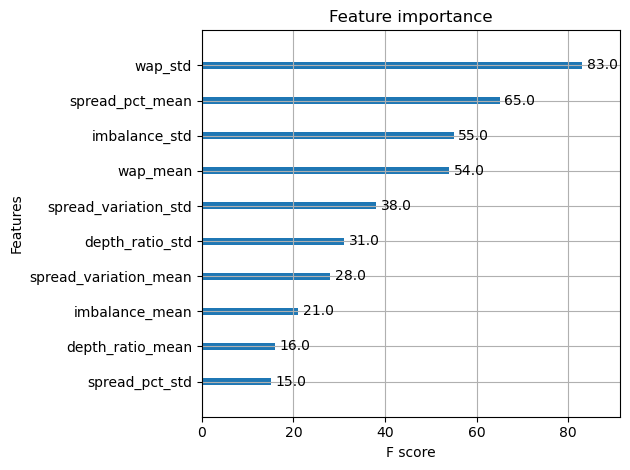

In [13]:

# XGBoost
model1 = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model1.fit(X_train, y_train)

def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None) 
    return np.mean(np.log(y_pred) + (y_true / y_pred))


y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print(f"MSE: {mse}")
print(f"QLIKE: {qlike_score:.6f}")

plot_importance(model1)
plt.tight_layout()
plt.show()

## add more feature and rolling window


In the Add Feature model stage, using additional engineered features, including:

- wap_std_10
- wap_mean_10
- wap_return 
- log_return


In [23]:

feature_agg = spy_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std'],
    'depth_ratio': ['mean', 'std'],
    'wap_return': ['mean',  'max'],
    'log_return': ['mean',  'max'],
    'wap_mean_10': ['mean', 'std'],
    'wap_std_10': ['mean', 'std']
})

feature_agg.columns = ['_'.join(col) for col in feature_agg.columns]
feature_agg = feature_agg.reset_index()

for col in feature_agg.columns:
    if col != 'time_id':
        feature_agg[f'{col}_lag1'] = feature_agg[col].shift(1)
        feature_agg[f'{col}_lag2'] = feature_agg[col].shift(2)


for col in feature_agg.columns:
    if col != 'time_id' and not col.endswith('lag1') and not col.endswith('lag2'):
        feature_agg[f'{col}_diff1'] = feature_agg[col].diff(1)



feature_agg = feature_agg.dropna().reset_index(drop=True)


data_2 = pd.merge(feature_agg, rv_df, on="time_id", how="inner")


In [25]:
W, H, S = 330, 5, 5 

all_preds = []
all_actuals = []
importance_list = []

feature_cols = [col for col in data_2.columns if col not in ['time_id', 'realized_volatility']]

for start in range(0, len(feature_agg) - W - H + 1, S):
    train = data_2.iloc[start:start + W]
    test = data_2.iloc[start + W:start + W + H]
    
    X_train, y_train = train[feature_cols], train['realized_volatility']
    X_test, y_test = test[feature_cols], test['realized_volatility']
    
    model = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=3888
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    all_preds.extend(preds)
    all_actuals.extend(y_test.values)
    booster = model.get_booster()
    imp_dict = booster.get_score(importance_type='gain')
    importance_list.append(imp_dict)

MSE: 3.979676682086812e-08
QLIKE: -11.873891


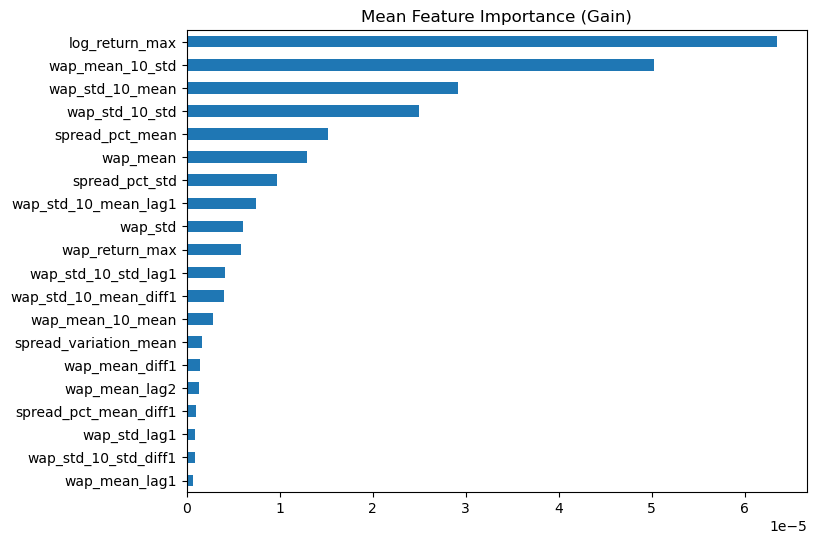

In [96]:

all_preds = np.array(all_preds)
all_actuals = np.array(all_actuals)

mse = mean_squared_error(all_actuals, all_preds)
print(f"MSE: {mse}")

epsilon = 1e-8
qlike = np.mean(np.log(all_preds**2 + epsilon) + (all_actuals**2) / (all_preds**2 + epsilon))
print(f"QLIKE: {qlike:.6f}")


importance_df = pd.DataFrame(importance_list).fillna(0)

# use the average of all models
mean_importance = importance_df.mean().sort_values(ascending=False)

# top 20 features impotance
mean_importance.head(20).plot(kind='barh', figsize=(8, 6), title="Mean Feature Importance (Gain)")
plt.gca().invert_yaxis()
plt.show()

## Hyperparameter Tuning

### depth and weight

In [98]:

W, H, S = 30, 5, 5
mid_start = (len(data_2) - W - H + 1) // 2
train_sample = data_2.iloc[mid_start:mid_start + W]

feature_cols = [col for col in data_2.columns if col not in ['time_id', 'realized_volatility']]
X_train = train_sample[feature_cols]
y_train = train_sample['realized_volatility']



param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=model_better,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best Parameters: {'max_depth': 1, 'min_child_weight': 7}
Best Score: -9.784641781319877e-07


### gamma

In [100]:
# Use the current best max_depth and min_child_weight to validate


model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=1,
    min_child_weight=7,
    random_state=3888
)

# Define the range for gamma
param_grid = {
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print("Best gamma:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best gamma: {'gamma': 0}
Best score: -9.784641781319877e-07


### subsample and colsample_bytree

In [49]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=1,
    min_child_weight=7,
    gamma=0,
    random_state=3888
)

# the range for subsample and colsample_bytree
param_grid = {
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best parameters: {'colsample_bytree': 0.5, 'subsample': 0.9}
Best score: -9.356678554908079e-07


In [53]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=1,
    min_child_weight=7,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.5,
    random_state=3888
)

param_grid = {
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1],   # L1 regularization
    'reg_lambda': [0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.5]  # L2 regularization
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best regularization parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best regularization parameters: {'reg_alpha': 0, 'reg_lambda': 0.6}
Best score: -9.237001412445315e-07


### final model

In [57]:
W, H, S = 330, 5, 5

all_preds = []
all_actuals = []
importance_list = []

feature_cols = [col for col in data_2.columns if col not in ['time_id', 'realized_volatility']]

for start in range(0, len(feature_agg) - W - H + 1, S):
    train = data_2.iloc[start:start + W]
    test = data_2.iloc[start + W:start + W + H]
    
    X_train, y_train = train[feature_cols], train['realized_volatility']
    X_test, y_test = test[feature_cols], test['realized_volatility']
    
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=1,
        min_child_weight=7,
        gamma=0,
        objective='reg:squarederror',
        subsample=0.9,
        colsample_bytree=0.5,
        reg_alpha=0,
        reg_lambda=0.6,
        random_state=3888
)
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    all_preds.extend(preds)
    all_actuals.extend(y_test.values)
    booster = model.get_booster()
    imp_dict = booster.get_score(importance_type='gain')
    importance_list.append(imp_dict)


MSE: 3.979676682086812e-08
QLIKE: -11.873891


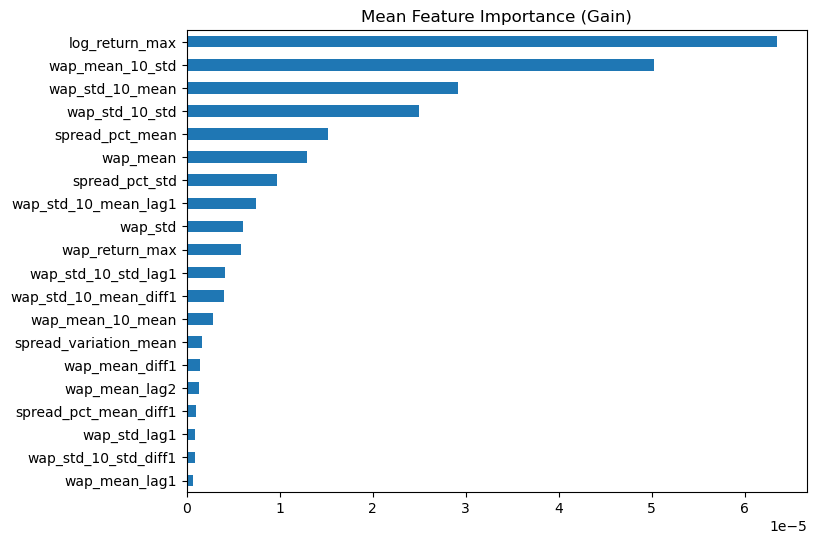

In [58]:

all_preds = np.array(all_preds)
all_actuals = np.array(all_actuals)

mse = mean_squared_error(all_actuals, all_preds)
print(f"MSE: {mse}")

epsilon = 1e-8
qlike = np.mean(np.log(all_preds**2 + epsilon) + (all_actuals**2) / (all_preds**2 + epsilon))
print(f"QLIKE: {qlike:.6f}")


importance_df = pd.DataFrame(importance_list).fillna(0)

# use the average of all models
mean_importance = importance_df.mean().sort_values(ascending=False)

# top 20 features impotance
mean_importance.head(20).plot(kind='barh', figsize=(8, 6), title="Mean Feature Importance (Gain)")
plt.gca().invert_yaxis()
plt.show()

## Visualization

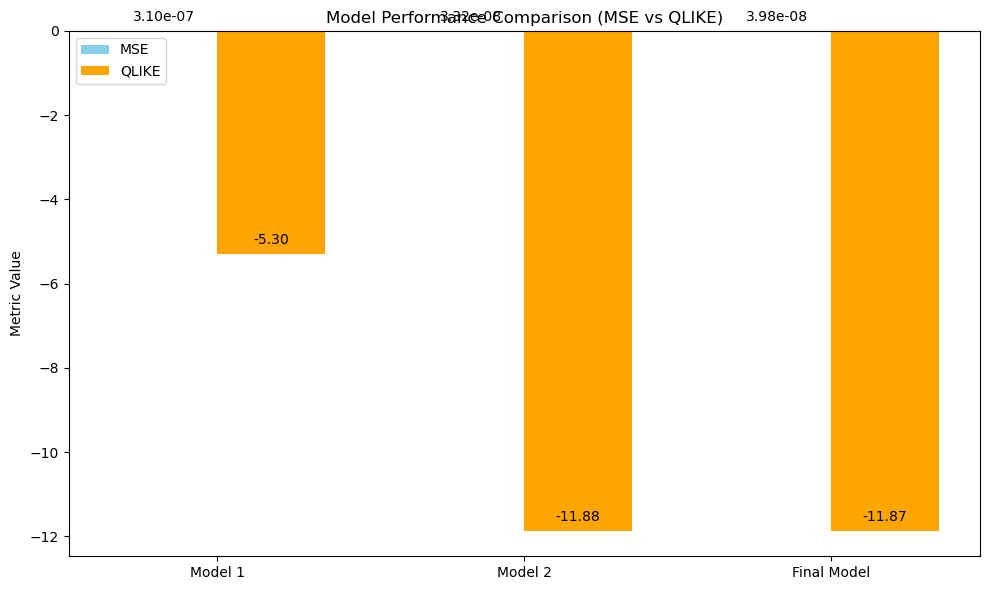

In [61]:


models = ['Model 1', 'Model 2', 'Final Model']
mse_values = [3.101096322373098e-07, 3.3244387817513774e-08, 3.979676682086812e-08]
qlike_values = [-5.299469, -11.876056, -11.873891]

x = np.arange(len(models)) 
width = 0.35         


fig, ax1 = plt.subplots(figsize=(10, 6))


bars1 = ax1.bar(x - width/2, mse_values, width, label='MSE', color='skyblue')

bars2 = ax1.bar(x + width/2, qlike_values, width, label='QLIKE', color='orange')

ax1.set_ylabel('Metric Value')
ax1.set_title('Model Performance Comparison (MSE vs QLIKE)')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()


for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.2e}' if abs(height) < 0.001 else f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()



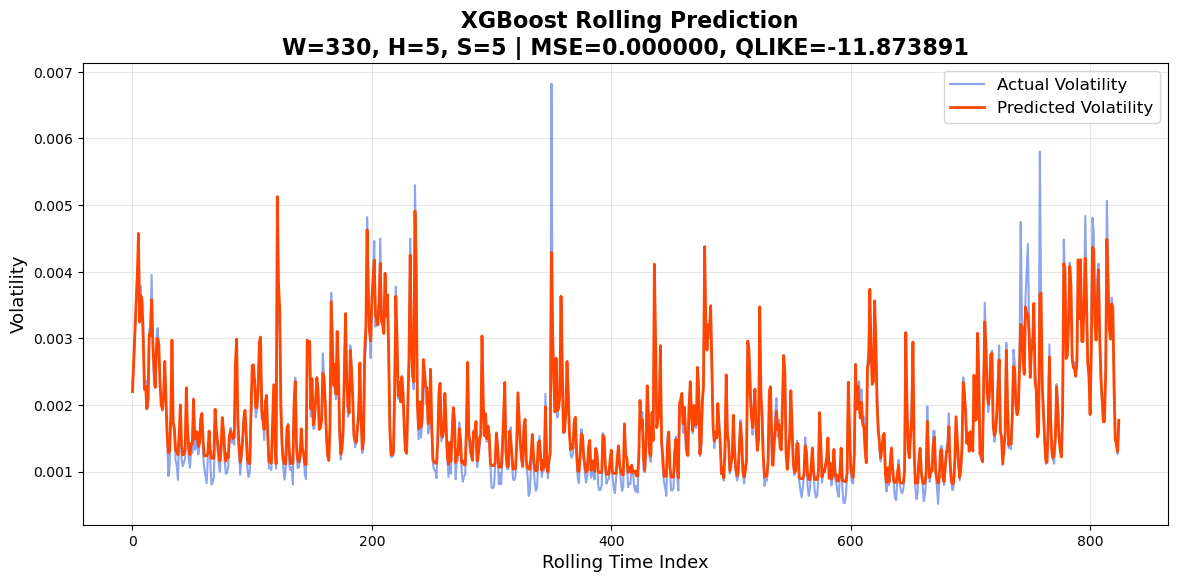

In [90]:
plt.figure(figsize=(14, 6))

plt.plot(all_actuals, label='Actual Volatility', color='royalblue', linewidth=1.5, alpha=0.6)
plt.plot(all_preds, label='Predicted Volatility', color='orangered', linewidth=2)

plt.title(f" XGBoost Rolling Prediction\nW={W}, H={H}, S={S} | MSE={mse:.6f}, QLIKE={qlike:.6f}",
          fontsize=16, fontweight='bold')
plt.xlabel("Rolling Time Index", fontsize=13)
plt.ylabel("Volatility", fontsize=13)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.show()

